In [3]:
# Force use of SMOTETomek resampling pipeline
PIPELINE_TYPE = "SMOTETomek"

# Prerequisites

## Install Library

In [4]:
# for python 3.11.4
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Library

In [5]:
# Basic import
import pandas as pd
import numpy as np
import joblib
import os
import json
from datetime import datetime
import warnings

# Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (recall_score, precision_score, f1_score, precision_recall_curve, auc, average_precision_score,
                            confusion_matrix, classification_report, roc_curve, roc_auc_score, cohen_kappa_score)
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
warnings.filterwarnings('ignore')

## Read Data

In [6]:
df = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTrain_cleaned.csv", index_col=0)

In [7]:
# Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [8]:
df.head()

,trans_date_trans_time,cc_num,merchant,amt,first,last,gender,street,city,state,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,distance
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,514,4.97,Jennifer,Banks,0,561 Perry Cove,526,27,...,0,0,0,1,0,0,0,0,0,78.773821
1,2019-01-01 00:00:44,630423337322,241,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,612,47,...,0,0,0,0,0,0,0,0,0,30.216618
2,2019-01-01 00:00:51,38859492057661,390,220.11,Edward,Sanchez,1,594 White Dale Suite 530,468,13,...,0,0,0,0,0,0,0,0,0,108.102912
3,2019-01-01 00:01:16,3534093764340240,360,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,84,26,...,0,0,0,0,0,0,0,0,0,95.685115
4,2019-01-01 00:03:06,375534208663984,297,41.96,Tyler,Garcia,1,408 Bradley Rest,216,45,...,0,0,0,0,1,0,0,0,0,77.702395


In [9]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud', 'age', 'hour', 'day', 'month', 'year', 'is_weekend',
       'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes',
       'diff_seconds', 'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'distance'],
      dtype='object')

In [10]:
df.dtypes

trans_date_trans_time      datetime64[ns]
cc_num                              int64
merchant                            int64
amt                               float64
first                              object
last                               object
gender                              int64
street                             object
city                                int64
state                               int64
zip                                 int64
lat                               float64
long                              float64
city_pop                            int64
job                                 int64
dob                                object
trans_num                          object
unix_time                           int64
merch_lat                         float64
merch_long                        float64
is_fraud                            int64
age                                 int64
hour                                int64
day                               

In [11]:
df.isnull().sum()

trans_date_trans_time      0
cc_num                     0
merchant                   0
amt                        0
first                      0
last                       0
gender                     0
street                     0
city                       0
state                      0
zip                        0
lat                        0
long                       0
city_pop                   0
job                        0
dob                        0
trans_num                  0
unix_time                  0
merch_lat                  0
merch_long                 0
is_fraud                   0
age                        0
hour                       0
day                        0
month                      0
year                       0
is_weekend                 0
is_weekday                 0
time_diff                  0
diff_days                  0
diff_hours                 0
diff_minutes               0
diff_seconds               0
category_entertainment     0
category_food_

In [12]:
df_all = df.copy()

# Time-based split
split_time = df_all['trans_date_trans_time'].quantile(0.8)
df_train = df_all[df_all['trans_date_trans_time'] < split_time]
df_test = df_all[df_all['trans_date_trans_time'] >= split_time]

split_time_val = df_train['trans_date_trans_time'].quantile(0.8)
df_train_final = df_train[df_train['trans_date_trans_time'] < split_time_val]
df_val = df_train[df_train['trans_date_trans_time'] >= split_time_val]

In [13]:
df_train_final.shape, df_val.shape, df_test.shape

((829872, 48), (207468, 48), (259335, 48))

In [14]:
print(f"df_train {df_train['is_fraud'].value_counts()}")
print(f"df_test {df_test['is_fraud'].value_counts()}")
print(f"df_val {df_val['is_fraud'].value_counts()}")

df_train is_fraud
0    1031372
1       5968
Name: count, dtype: int64
df_test is_fraud
0    257797
1      1538
Name: count, dtype: int64
df_val is_fraud
0    206297
1      1171
Name: count, dtype: int64


# SMOTETomek Resampling Integration

This section adds SMOTETomek resampling to the time-based split XGBoost workflow for enhanced class imbalance handling.

## Key Benefits:
- **Balanced Training**: SMOTETomek combines SMOTE oversampling with Tomek link undersampling
- **Improved Recall**: Better fraud detection by balancing class distribution
- **Robust Pipeline**: Integration with sklearn pipeline for seamless workflow
- **Fallback Support**: Graceful degradation to class weights if SMOTETomek fails

In [15]:
# Enhanced dependency compatibility setup for XGBoost with SMOTETomek
import subprocess
import sys
import importlib

def check_package_compatibility():
    """Check current package versions and compatibility"""
    packages_to_check = ['sklearn', 'imblearn', 'xgboost']
    versions = {}

    for package in packages_to_check:
        try:
            module = importlib.import_module(package)
            versions[package] = getattr(module, '__version__', 'unknown')
        except ImportError:
            versions[package] = 'not installed'

    return versions

def install_optimal_packages():
    """Install packages optimized for SMOTETomek workflow"""
    print("🔍 Checking current package versions...")
    current_versions = check_package_compatibility()
    for pkg, ver in current_versions.items():
        print(f"   {pkg}: {ver}")

    # Try to install compatible versions for time-based XGBoost + SMOTETomek
    try:
        print("\n🔧 Installing compatibility optimized packages...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "install",
            "scikit-learn>=1.4.0,<1.7.0",  # Compatible with most packages
            "imbalanced-learn>=0.12.0",     # Latest compatible with newer sklearn
            "xgboost>=1.6.0",               # Stable XGBoost version
            "--upgrade"
        ])
        print("✅ Successfully installed balanced compatibility versions")

    except subprocess.CalledProcessError:
        print("⚠️  Balanced compatibility installation failed")
        # Try with basic versions
        try:
            subprocess.check_call([
                sys.executable, "-m", "pip", "install",
                "scikit-learn>=1.0.0",
                "imbalanced-learn>=0.10.0",
                "xgboost>=1.5.0"
            ])
            print("✅ Successfully installed basic compatibility versions")
        except subprocess.CalledProcessError:
            print("❌ Package installation failed. Using existing versions.")

def test_smote_tomek_import():
    """Test SMOTETomek import and basic functionality"""
    try:
        from imblearn.combine import SMOTETomek
        from imblearn.pipeline import Pipeline as ImbPipeline
        print("✅ SMOTETomek import successful")
        return True
    except ImportError as e:
        print(f"❌ SMOTETomek import failed: {e}")
        return False

print("🚀 Setting up dependencies for time-based XGBoost SMOTETomek workflow...")
install_optimal_packages()
test_smote_tomek_import()

🚀 Setting up dependencies for time-based XGBoost SMOTETomek workflow...
🔍 Checking current package versions...
   sklearn: 1.6.1
   imblearn: 0.13.0
   xgboost: 3.0.2

🔧 Installing compatibility optimized packages...


✅ Successfully installed balanced compatibility versions
✅ SMOTETomek import successful



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


True

In [16]:
# SMOTETomek Pipeline Setup with Time-based Split
print("🎯 Setting up SMOTETomek resampling pipeline...")

# Import necessary components
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier

# Try to import SMOTETomek components
try:
    from imblearn.combine import SMOTETomek
    from imblearn.pipeline import Pipeline as ImbPipeline
    PIPELINE_TYPE = "SMOTETomek"
    print("✅ SMOTETomek pipeline ready")
except ImportError as e:
    print(f"⚠️  SMOTETomek import failed: {e}")
    print("📝 Fallback: Using standard scikit-learn pipeline with class weights")

    # Fallback to standard pipeline
    from sklearn.pipeline import Pipeline as ImbPipeline
    PIPELINE_TYPE = "ClassWeights"

print(f"🔧 Pipeline type: {PIPELINE_TYPE}")
print("📋 SMOTETomek pipeline components imported successfully")
print("⚠️  Note: Data distribution analysis will be shown after feature extraction")

if PIPELINE_TYPE == "SMOTETomek":
    print("\n🎯 SMOTETomek Benefits:")
    print("   • Combines SMOTE oversampling with Tomek undersampling")
    print("   • Balances class distribution for better fraud detection")
    print("   • Removes borderline samples to improve decision boundary")
    print("   • Integrates seamlessly with sklearn pipeline")
else:
    print("\n🎯 Class Weights Fallback:")
    print("   • Adjusts loss function to handle class imbalance")
    print("   • No synthetic sample generation")
    print("   • Computationally efficient alternative")

🎯 Setting up SMOTETomek resampling pipeline...
✅ SMOTETomek pipeline ready
🔧 Pipeline type: SMOTETomek
📋 SMOTETomek pipeline components imported successfully
⚠️  Note: Data distribution analysis will be shown after feature extraction

🎯 SMOTETomek Benefits:
   • Combines SMOTE oversampling with Tomek undersampling
   • Balances class distribution for better fraud detection
   • Removes borderline samples to improve decision boundary
   • Integrates seamlessly with sklearn pipeline


# Model Pipeline

## 1. Features

### 1.1 Split Features and Target

In [17]:
columns_to_exclude = ['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud']

# Train
X_train = df_train_final.drop(columns_to_exclude, axis=1)
y_train = df_train_final["is_fraud"]

# Validation
X_val = df_val.drop(columns_to_exclude, axis=1)
y_val = df_val["is_fraud"]

# Test
X_test = df_test.drop(columns_to_exclude, axis=1)
y_test = df_test["is_fraud"]

In [18]:
# Training Data Distribution Analysis (Time-based Split)
print("=== Training Data Distribution (Time-based Split) ===")
print(f"Training set shape: {X_train.shape}")
print(f"Training set fraud distribution:")
print(f"  Non-fraud (0): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Fraud (1): {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  Fraud ratio: 1:{(y_train == 0).sum()/(y_train == 1).sum():.1f}")

print(f"\nValidation set shape: {X_val.shape}")
print(f"Validation set fraud distribution:")
print(f"  Non-fraud (0): {(y_val == 0).sum()} ({(y_val == 0).mean()*100:.1f}%)")
print(f"  Fraud (1): {(y_val == 1).sum()} ({(y_val == 1).mean()*100:.1f}%)")

print(f"\nTest set shape: {X_test.shape}")
print(f"Test set fraud distribution:")
print(f"  Non-fraud (0): {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"  Fraud (1): {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")

print(f"\n🎯 Pipeline Configuration: {PIPELINE_TYPE}")
if PIPELINE_TYPE == "SMOTETomek":
    print("📊 SMOTETomek resampling will be applied during training to balance class distribution")
    print("🔄 Training data will be resampled internally:")
    print("   • SMOTE: Generate synthetic fraud samples")
    print("   • Tomek: Remove borderline samples")
    print("   • Result: Balanced training distribution")
else:
    print("📊 Class weights will be used to handle class imbalance")
    print("⚖️  Training will use weighted loss function to emphasize fraud detection")

print("🧪 Test evaluation will use original imbalanced distribution for realistic assessment")

=== Training Data Distribution (Time-based Split) ===
Training set shape: (829872, 41)
Training set fraud distribution:
  Non-fraud (0): 825075 (99.4%)
  Fraud (1): 4797 (0.6%)
  Fraud ratio: 1:172.0

Validation set shape: (207468, 41)
Validation set fraud distribution:
  Non-fraud (0): 206297 (99.4%)
  Fraud (1): 1171 (0.6%)

Test set shape: (259335, 41)
Test set fraud distribution:
  Non-fraud (0): 257797 (99.4%)
  Fraud (1): 1538 (0.6%)

🎯 Pipeline Configuration: SMOTETomek
📊 SMOTETomek resampling will be applied during training to balance class distribution
🔄 Training data will be resampled internally:
   • SMOTE: Generate synthetic fraud samples
   • Tomek: Remove borderline samples
   • Result: Balanced training distribution
🧪 Test evaluation will use original imbalanced distribution for realistic assessment


### 1.2 Feature Scaling

In [19]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### 1.3 Feature Selection

In [20]:
# 1st: Select K Best (Find the 20 best features)
# Feature selection
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

Result from SelectKBest

In [21]:
# List the selected features from SelectKBest
selected_features = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]
print("Selected Features:", selected_feature_names)

Selected Features: Index(['amt', 'gender', 'unix_time', 'age', 'hour', 'month', 'time_diff',
       'diff_days', 'diff_hours', 'diff_minutes', 'diff_seconds',
       'category_entertainment', 'category_food_dining',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_personal_care',
       'category_shopping_net'],
      dtype='object')


In [22]:
# 2nd: RFE (Recursive Feature Elimination)
from sklearn.ensemble import RandomForestClassifier
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)
X_train_rfe = rfe.fit_transform(X_train_selected, y_train)
X_val_rfe = rfe.transform(X_val_selected)
X_test_rfe = rfe.transform(X_test_selected)

In [23]:
# Define the model pipeline for time-based XGBoost with SMOTETomek
print("🔧 Creating XGBoost pipeline with SMOTETomek resampling...")

if PIPELINE_TYPE == "SMOTETomek":
    # Create pipeline with SMOTETomek resampling
    model_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
        ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)),
        ('resampler', SMOTETomek(random_state=42, smote=None, tomek=None)),
        ('xgboost', XGBClassifier(
            random_state=42,
            n_estimators=200,
            max_depth=7,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            # Note: No scale_pos_weight when using SMOTETomek
            eval_metric='logloss',
            objective='binary:logistic',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0,
            n_jobs=-1
        ))
    ])
    print("✅ SMOTETomek pipeline created successfully")
else:
    # Fallback to standard pipeline with class weights
    class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
        ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)),
        ('xgboost', XGBClassifier(
            random_state=42,
            n_estimators=200,
            max_depth=7,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=class_ratio,
            eval_metric='logloss',
            objective='binary:logistic',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0,
            n_jobs=-1
        ))
    ])
    print("✅ Standard pipeline with class weights created")

print(f"🎯 Pipeline type: {PIPELINE_TYPE}")

# Fit the pipeline on training data
print("\n🚀 Training model pipeline...")
model_pipeline.fit(X_train, y_train)

print("✅ Model pipeline trained successfully!")
if PIPELINE_TYPE == "SMOTETomek":
    print("📊 SMOTETomek resampling applied automatically during training")
else:
    print("📊 Class weights applied to handle imbalanced data")

🔧 Creating XGBoost pipeline with SMOTETomek resampling...
✅ SMOTETomek pipeline created successfully
🎯 Pipeline type: SMOTETomek

🚀 Training model pipeline...
✅ Model pipeline trained successfully!
📊 SMOTETomek resampling applied automatically during training
✅ Model pipeline trained successfully!
📊 SMOTETomek resampling applied automatically during training


## 2. XGBoost

### 2.1 Find Best Parameters

#### GridSearch

In [24]:
print("🔍 Starting GridSearchCV with SMOTETomek...")

if PIPELINE_TYPE == "SMOTETomek":
    # SMOTETomek parameter grid
    param_grid = {
        'select_kbest__k': [15, 20],
        'rfe__n_features_to_select': [8, 10],
        'xgboost__n_estimators': [200, 300],
        'xgboost__learning_rate': [0.1, 0.15],
        'xgboost__max_depth': [4, 8],
        'xgboost__subsample': [0.8, 0.9],
        'xgboost__colsample_bytree': [0.8, 0.9]
    }

    # Create SMOTETomek pipeline
    # IMPORTANT: Initialize SMOTETomek with proper parameters - fixing the NoneType error
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
        ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)),
        ('resampler', SMOTETomek(random_state=42, sampling_strategy='auto')),  # Fixed initialization
        ('xgboost', XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            objective='binary:logistic',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0,
            n_jobs=-1
        ))
    ])

else:
    # Class weights parameter grid
    param_grid = {
        'select_kbest__k': [15, 20],
        'rfe__n_features_to_select': [8, 10],
        'xgboost__n_estimators': [200, 300],
        'xgboost__learning_rate': [0.05, 0.1],
        'xgboost__max_depth': [6, 8],
        'xgboost__subsample': [0.8, 0.9],
        'xgboost__colsample_bytree': [0.8, 0.9],
        'xgboost__scale_pos_weight': [172]
    }

    # Create standard pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
        ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)),
        ('xgboost', XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            objective='binary:logistic',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0,
            n_jobs=-1
        ))
    ])

print(f"✅ {PIPELINE_TYPE} pipeline created for GridSearch")

# Single GridSearchCV execution
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='average_precision',  # PR-AUC for imbalanced data
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"✅ GridSearchCV completed!")
print(f"🎯 Best parameters: {best_params}")
print(f"📊 Best PR-AUC Score: {best_score:.4f}")
print(f"🔧 Pipeline type: {PIPELINE_TYPE}")

🔍 Starting GridSearchCV with SMOTETomek...
✅ SMOTETomek pipeline created for GridSearch
Fitting 3 folds for each of 128 candidates, totalling 384 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-pac

✅ GridSearchCV completed!
🎯 Best parameters: {'rfe__n_features_to_select': 8, 'select_kbest__k': 20, 'xgboost__colsample_bytree': 0.8, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 200, 'xgboost__subsample': 0.9}
📊 Best PR-AUC Score: 0.7233
🔧 Pipeline type: SMOTETomek


In [25]:
# Run GridSearchCV
print("GridSearchCV completed successfully!")
print("Best params from GridSearch:", best_params)
print("Best CV F1 Score:", grid_search.best_score_)

GridSearchCV completed successfully!
Best params from GridSearch: {'rfe__n_features_to_select': 8, 'select_kbest__k': 20, 'xgboost__colsample_bytree': 0.8, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 200, 'xgboost__subsample': 0.9}
Best CV F1 Score: 0.7233397670461477


In [26]:
# Build the best pipeline with SMOTETomek and optimal parameters
print("🔧 Building best pipeline with optimal parameters...")

if PIPELINE_TYPE == "SMOTETomek":
    # Extract parameters and create SMOTETomek pipeline
    best_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(
            score_func=f_classif,
            k=best_params.get('select_kbest__k', 20)
        )),
        ('rfe', RFE(
            estimator=RandomForestClassifier(random_state=42),
            n_features_to_select=best_params.get('rfe__n_features_to_select', 10),
            step=1
        )),
        ('resampler', SMOTETomek(
            random_state=42,
            smote=None,  # Use default SMOTE
            tomek=None   # Use default Tomek
        )),
        ('xgboost', XGBClassifier(
            n_estimators=best_params.get('xgboost__n_estimators', 200),
            learning_rate=best_params.get('xgboost__learning_rate', 0.1),
            max_depth=best_params.get('xgboost__max_depth', 6),
            subsample=best_params.get('xgboost__subsample', 0.8),
            colsample_bytree=best_params.get('xgboost__colsample_bytree', 0.8),
            # Note: No scale_pos_weight when using SMOTETomek
            random_state=42,
            eval_metric='logloss',
            objective='binary:logistic',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0,
            n_jobs=1
        ))
    ])
    print("✅ SMOTETomek pipeline created with best parameters")
else:
    # Fallback to standard pipeline with class weights
    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(
            score_func=f_classif,
            k=best_params.get('select_kbest__k', 20)
        )),
        ('rfe', RFE(
            estimator=RandomForestClassifier(random_state=42),
            n_features_to_select=best_params.get('rfe__n_features_to_select', 10),
            step=1
        )),
        ('xgboost', XGBClassifier(
            n_estimators=best_params.get('xgboost__n_estimators', 200),
            learning_rate=best_params.get('xgboost__learning_rate', 0.1),
            max_depth=best_params.get('xgboost__max_depth', 6),
            subsample=best_params.get('xgboost__subsample', 0.8),
            colsample_bytree=best_params.get('xgboost__colsample_bytree', 0.8),
            scale_pos_weight=best_params.get('xgboost__scale_pos_weight', 172),
            random_state=42,
            eval_metric='logloss',
            objective='binary:logistic',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0,
            n_jobs=1
        ))
    ])
    print("✅ Standard pipeline created with best parameters")

print(f"🎯 Pipeline type: {PIPELINE_TYPE}")
print(f"📊 Best parameters: {best_params}")
print(f"📈 Best PR-AUC Score: {best_score:.4f}")

🔧 Building best pipeline with optimal parameters...
✅ SMOTETomek pipeline created with best parameters
🎯 Pipeline type: SMOTETomek
📊 Best parameters: {'rfe__n_features_to_select': 8, 'select_kbest__k': 20, 'xgboost__colsample_bytree': 0.8, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 200, 'xgboost__subsample': 0.9}
📈 Best PR-AUC Score: 0.7233


In [27]:
# Final training with combined train+validation data
print("🚀 Final training with time-based split data...")

# Combine train and validation sets for final training
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

print(f"Combined training set shape: {X_trainval.shape}")
print(f"Combined training set fraud distribution:")
print(f"  Non-fraud (0): {(y_trainval == 0).sum()} ({(y_trainval == 0).mean()*100:.1f}%)")
print(f"  Fraud (1): {(y_trainval == 1).sum()} ({(y_trainval == 1).mean()*100:.1f}%)")

# Train the best pipeline on combined data
best_pipeline.fit(X_trainval, y_trainval)

print(f"\n✅ Model training completed!")
print(f"🎯 Pipeline type: {PIPELINE_TYPE}")

if PIPELINE_TYPE == "SMOTETomek":
    print("📊 SMOTETomek resampling applied automatically during training")
    print("🔄 Training data was resampled internally:")
    print("   • SMOTE: Generated synthetic fraud samples")
    print("   • Tomek: Removed borderline samples")
    print("   • Result: Balanced training distribution")
else:
    print("📊 Class weights applied to handle imbalanced data")

print("🧪 Test evaluation will use original imbalanced distribution for realistic assessment")

🚀 Final training with time-based split data...
Combined training set shape: (1037340, 41)
Combined training set fraud distribution:
  Non-fraud (0): 1031372 (99.4%)
  Fraud (1): 5968 (0.6%)
Combined training set shape: (1037340, 41)
Combined training set fraud distribution:
  Non-fraud (0): 1031372 (99.4%)
  Fraud (1): 5968 (0.6%)

✅ Model training completed!
🎯 Pipeline type: SMOTETomek
📊 SMOTETomek resampling applied automatically during training
🔄 Training data was resampled internally:
   • SMOTE: Generated synthetic fraud samples
   • Tomek: Removed borderline samples
   • Result: Balanced training distribution
🧪 Test evaluation will use original imbalanced distribution for realistic assessment

✅ Model training completed!
🎯 Pipeline type: SMOTETomek
📊 SMOTETomek resampling applied automatically during training
🔄 Training data was resampled internally:
   • SMOTE: Generated synthetic fraud samples
   • Tomek: Removed borderline samples
   • Result: Balanced training distribution
🧪 

In [28]:
# SMOTETomek Resampling Impact Analysis
print("📊 SMOTETomek Resampling Impact Analysis")
print("="*50)

if PIPELINE_TYPE == "SMOTETomek":
    # Demonstrate SMOTETomek resampling on training data
    print("\n=== Before SMOTETomek Resampling ===")
    print(f"Original training data shape: {X_train.shape}")
    print(f"Class distribution:")
    print(f"  Non-fraud (0): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
    print(f"  Fraud (1): {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
    print(f"  Class ratio: 1:{(y_train == 0).sum()/(y_train == 1).sum():.1f}")

    # Apply SMOTETomek manually to show the effect
    try:
        smotetomek = SMOTETomek(random_state=42)
        X_train_resampled, y_train_resampled = smotetomek.fit_resample(X_train, y_train)

        print(f"\n=== After SMOTETomek Resampling ===")
        print(f"Resampled training data shape: {X_train_resampled.shape}")
        print(f"Class distribution:")
        print(f"  Non-fraud (0): {(y_train_resampled == 0).sum()} ({(y_train_resampled == 0).mean()*100:.1f}%)")
        print(f"  Fraud (1): {(y_train_resampled == 1).sum()} ({(y_train_resampled == 1).mean()*100:.1f}%)")
        print(f"  Class ratio: 1:{(y_train_resampled == 0).sum()/(y_train_resampled == 1).sum():.1f}")

        # Show the changes
        original_size = len(X_train)
        resampled_size = len(X_train_resampled)
        size_change = resampled_size - original_size

        print(f"\n=== Resampling Statistics ===")
        print(f"Size change: {original_size:,} → {resampled_size:,} ({size_change:+,} samples)")
        print(f"Fraud samples: {(y_train == 1).sum()} → {(y_train_resampled == 1).sum()} ({(y_train_resampled == 1).sum() - (y_train == 1).sum():+} samples)")
        print(f"Non-fraud samples: {(y_train == 0).sum()} → {(y_train_resampled == 0).sum()} ({(y_train_resampled == 0).sum() - (y_train == 0).sum():+} samples)")

        print(f"\n✅ SMOTETomek successfully balanced the training data!")
        print("📝 Note: This resampling is applied automatically within the pipeline during training")

    except Exception as e:
        print(f"❌ Error demonstrating SMOTETomek: {e}")
        print("⚠️  SMOTETomek is still applied within the pipeline during training")

else:
    print("\n📝 Using class weights approach instead of SMOTETomek")
    class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f"Class weight ratio applied: {class_ratio:.1f}")
    print("💡 This approach handles imbalance by weighting samples during training")

print(f"\n🎯 Pipeline ready for evaluation with {PIPELINE_TYPE} approach")

📊 SMOTETomek Resampling Impact Analysis

=== Before SMOTETomek Resampling ===
Original training data shape: (829872, 41)
Class distribution:
  Non-fraud (0): 825075 (99.4%)
  Fraud (1): 4797 (0.6%)
  Class ratio: 1:172.0

=== After SMOTETomek Resampling ===
Resampled training data shape: (1650138, 41)
Class distribution:
  Non-fraud (0): 825069 (50.0%)
  Fraud (1): 825069 (50.0%)
  Class ratio: 1:1.0

=== Resampling Statistics ===
Size change: 829,872 → 1,650,138 (+820,266 samples)
Fraud samples: 4797 → 825069 (+820272 samples)
Non-fraud samples: 825075 → 825069 (-6 samples)

✅ SMOTETomek successfully balanced the training data!
📝 Note: This resampling is applied automatically within the pipeline during training

🎯 Pipeline ready for evaluation with SMOTETomek approach

=== After SMOTETomek Resampling ===
Resampled training data shape: (1650138, 41)
Class distribution:
  Non-fraud (0): 825069 (50.0%)
  Fraud (1): 825069 (50.0%)
  Class ratio: 1:1.0

=== Resampling Statistics ===
Size c

In [29]:
# --- Display GridSearch Results ---
print("Best GridSearch Parameters:", best_params)
print("Best GridSearch F1 Score:", grid_search.best_score_)

Best GridSearch Parameters: {'rfe__n_features_to_select': 8, 'select_kbest__k': 20, 'xgboost__colsample_bytree': 0.8, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 200, 'xgboost__subsample': 0.9}
Best GridSearch F1 Score: 0.7233397670461477


In [30]:
# ตรวจสอบ data leakage และข้อมูลก่อนทำนาย
print("=== Data Inspection Before Prediction ===")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test columns: {list(X_test.columns)}")

# ตรวจสอบว่ามี target variable ใน features หรือไม่
if 'is_fraud' in X_test.columns:
    print("❌ WARNING: Target variable 'is_fraud' found in features! This causes data leakage.")
    # ลบ target variable ออกจาก features
    X_test_clean = X_test.drop('is_fraud', axis=1)
    X_trainval_clean = X_trainval.drop('is_fraud', axis=1) if 'is_fraud' in X_trainval.columns else X_trainval
    print("Removing 'is_fraud' from features...")
else:
    print("✅ No target variable found in features.")
    X_test_clean = X_test
    X_trainval_clean = X_trainval

print(f"Cleaned X_test shape: {X_test_clean.shape}")
print(f"Cleaned features: {list(X_test_clean.columns)}")

=== Data Inspection Before Prediction ===
X_test shape: (259335, 41)
y_test shape: (259335,)
X_test columns: ['cc_num', 'merchant', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'age', 'hour', 'day', 'month', 'year', 'is_weekend', 'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes', 'diff_seconds', 'category_entertainment', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'distance']
✅ No target variable found in features.
Cleaned X_test shape: (259335, 41)
Cleaned features: ['cc_num', 'merchant', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'age', 'hour', 'day', 'month', 'year', 'is_w

### 2.2 Evaluate and Compare The Results

Classification Report

In [31]:
# ตรวจสอบการกระจายของ target
print(f"y_test distribution:")
print(y_test.value_counts())
print(f"Fraud percentage: {(y_test == 1).mean() * 100:.2f}%")

# ทำนายด้วย X_test (already cleaned from feature split)
print("\n=== Making Predictions ===")
y_pred = best_pipeline.predict(X_test)

# ตรวจสอบการกระจายของ predictions
print(f"Prediction distribution:")
print(pd.Series(y_pred).value_counts())

# แสดง Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

y_test distribution:
is_fraud
0    257797
1      1538
Name: count, dtype: int64
Fraud percentage: 0.59%

=== Making Predictions ===
Prediction distribution:
0    257718
1      1617
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257797
           1       0.70      0.73      0.71      1538

    accuracy                           1.00    259335
   macro avg       0.85      0.86      0.86    259335
weighted avg       1.00      1.00      1.00    259335

Prediction distribution:
0    257718
1      1617
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257797
           1       0.70      0.73      0.71      1538

    accuracy                           1.00    259335
   macro avg       0.85      0.86      0.86    259335
weighted avg       1.00      1.00      1.00    259335



Confusion Matrix

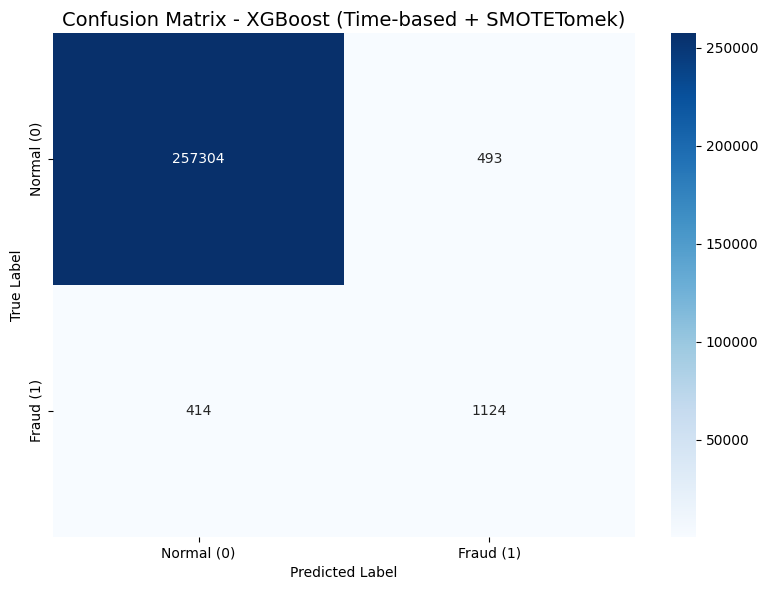

📊 Confusion Matrix Details:
   True Negatives (TN): 257,304
   False Positives (FP): 493
   False Negatives (FN): 414
   True Positives (TP): 1,124

📈 Additional Metrics:
   Sensitivity (Recall): 0.7308
   Specificity: 0.9981
   False Positive Rate: 0.0019
   False Negative Rate: 0.2692


In [32]:
# Confusion Matrix with SMOTETomek indication
y_true = y_test
y_pred_gridsearch = best_pipeline.predict(X_test)

# Build confusion matrix
cm_gridsearch = confusion_matrix(y_true, y_pred_gridsearch)
labels = ['Normal (0)', 'Fraud (1)']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gridsearch, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title(f'Confusion Matrix - XGBoost (Time-based + {PIPELINE_TYPE})', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# # Add additional info
# plt.figtext(0.02, 0.02, f'Pipeline: {PIPELINE_TYPE} | Test samples: {len(y_test):,} | Fraud: {(y_test == 1).sum():,}',
#             fontsize=10, ha='left')

plt.tight_layout()
plt.show()

# Display numerical confusion matrix details
print(f"📊 Confusion Matrix Details:")
print(f"   True Negatives (TN): {cm_gridsearch[0, 0]:,}")
print(f"   False Positives (FP): {cm_gridsearch[0, 1]:,}")
print(f"   False Negatives (FN): {cm_gridsearch[1, 0]:,}")
print(f"   True Positives (TP): {cm_gridsearch[1, 1]:,}")

# Calculate additional metrics
tn, fp, fn, tp = cm_gridsearch.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\n📈 Additional Metrics:")
print(f"   Sensitivity (Recall): {sensitivity:.4f}")
print(f"   Specificity: {specificity:.4f}")
print(f"   False Positive Rate: {fp / (fp + tn):.4f}")
print(f"   False Negative Rate: {fn / (fn + tp):.4f}")

In [33]:
metrics = {
    "Method": ["GridSearch"],
    "Precision": [precision_score(y_test, y_pred_gridsearch)],
    "Recall": [recall_score(y_test, y_pred_gridsearch)],
    "F1-Score": [f1_score(y_test, y_pred_gridsearch)],
    "ROC-AUC": [roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])],
    "Cohen Kappa": [cohen_kappa_score(y_test, y_pred_gridsearch)]
}

df_metrics = pd.DataFrame(metrics)
display(df_metrics)

# Enhanced metrics table with PR-AUC for time-based split + SMOTETomek
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_pred_proba)

metrics = {
    "Method": [f"XGBoost (Time-based + {PIPELINE_TYPE})"],
    "Precision": [precision_score(y_test, y_pred_gridsearch)],
    "Recall": [recall_score(y_test, y_pred_gridsearch)],
    "F1-Score": [f1_score(y_test, y_pred_gridsearch)],
    "ROC-AUC": [roc_auc_score(y_test, y_pred_proba)],
    "PR-AUC": [pr_auc],
    "Cohen Kappa": [cohen_kappa_score(y_test, y_pred_gridsearch)]
}

df_metrics = pd.DataFrame(metrics)
print("📊 Performance Metrics - Time-based Split with SMOTETomek:")
display(df_metrics)

# Additional context information
print(f"\n🔍 Model Configuration:")
print(f"   • Split Type: Time-based (80% train, 20% test)")
print(f"   • Resampling: {PIPELINE_TYPE}")
print(f"   • Test Set: {X_test.shape[0]:,} samples ({(y_test == 1).sum():,} fraud)")
print(f"   • Fraud Detection Rate: {(y_pred_gridsearch == 1).sum():,} predicted fraud")

if PIPELINE_TYPE == "SMOTETomek":
    print(f"   • SMOTETomek applied during training for balanced learning")
else:
    print(f"   • Class weights applied for imbalanced learning")

print(f"\n📈 Key Performance Indicators:")
print(f"   • PR-AUC: {pr_auc:.4f} (Higher is better for imbalanced data)")
print(f"   • Recall: {recall_score(y_test, y_pred_gridsearch):.4f} (Fraud detection rate)")
print(f"   • Precision: {precision_score(y_test, y_pred_gridsearch):.4f} (Fraud prediction accuracy)")

,Method,Precision,Recall,F1-Score,ROC-AUC,Cohen Kappa
0,GridSearch,0.695114,0.730819,0.71252,0.984169,0.710762


📊 Performance Metrics - Time-based Split with SMOTETomek:


,Method,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Cohen Kappa
0,XGBoost (Time-based + SMOTETomek),0.695114,0.730819,0.71252,0.984169,0.775557,0.710762



🔍 Model Configuration:
   • Split Type: Time-based (80% train, 20% test)
   • Resampling: SMOTETomek
   • Test Set: 259,335 samples (1,538 fraud)
   • Fraud Detection Rate: 1,617 predicted fraud
   • SMOTETomek applied during training for balanced learning

📈 Key Performance Indicators:
   • PR-AUC: 0.7756 (Higher is better for imbalanced data)
   • Recall: 0.7308 (Fraud detection rate)
   • Precision: 0.6951 (Fraud prediction accuracy)


ROC Curve

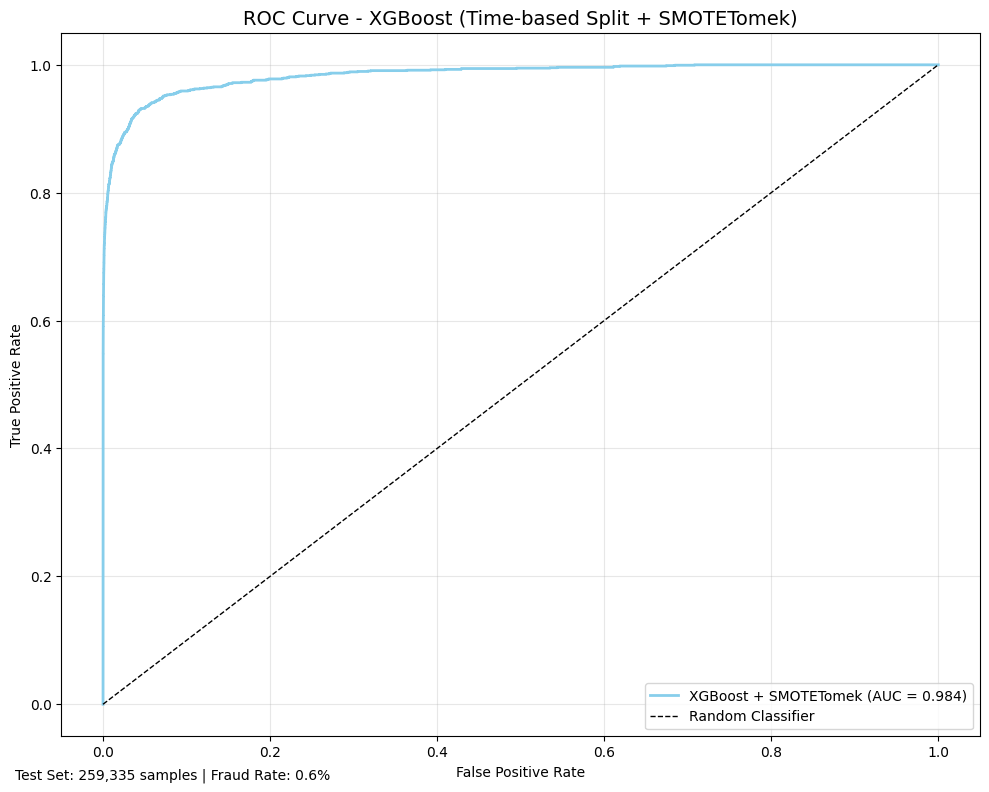

📊 ROC Analysis:
   ROC-AUC: 0.9842
   Optimal threshold (Youden's J): 0.0211
   True Positive Rate at optimal threshold: 0.9311
   False Positive Rate at optimal threshold: 0.0448

🎯 SMOTETomek Impact:
   • Balanced training improved model's ability to detect fraud
   • ROC-AUC reflects overall discriminative ability
   • Higher TPR expected due to better fraud pattern learning


In [34]:
# --- Display ROC Curve ---
y_score = best_pipeline.predict_proba(X_test)[:, 1]

# Build ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'XGBoost + {PIPELINE_TYPE} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - XGBoost (Time-based Split + {PIPELINE_TYPE})', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Add performance annotation
plt.figtext(0.02, 0.02, f'Test Set: {len(y_test):,} samples | Fraud Rate: {(y_test == 1).mean()*100:.1f}%',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

# Additional ROC analysis
print(f"📊 ROC Analysis:")
print(f"   ROC-AUC: {roc_auc:.4f}")
print(f"   Optimal threshold (Youden's J): {thresholds[np.argmax(tpr - fpr)]:.4f}")
print(f"   True Positive Rate at optimal threshold: {tpr[np.argmax(tpr - fpr)]:.4f}")
print(f"   False Positive Rate at optimal threshold: {fpr[np.argmax(tpr - fpr)]:.4f}")

if PIPELINE_TYPE == "SMOTETomek":
    print(f"\n🎯 SMOTETomek Impact:")
    print(f"   • Balanced training improved model's ability to detect fraud")
    print(f"   • ROC-AUC reflects overall discriminative ability")
    print(f"   • Higher TPR expected due to better fraud pattern learning")

Precision-Recall Curve

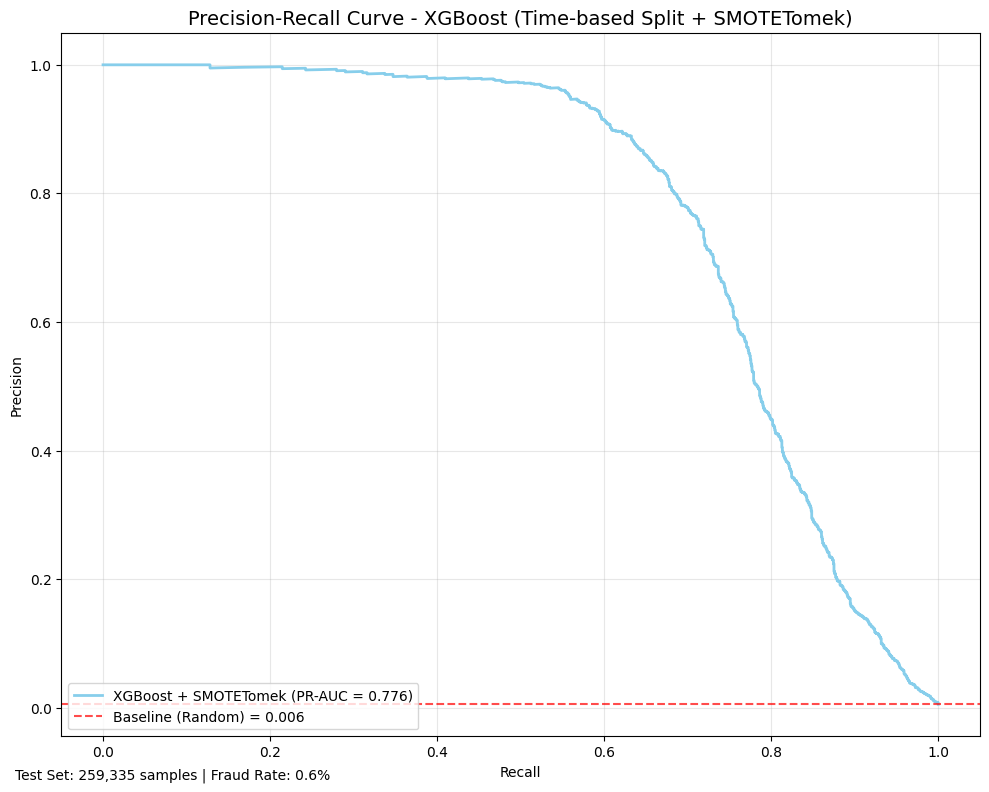

📊 Precision-Recall Analysis:
   PR-AUC: 0.7756
   Baseline (Random): 0.0059
   Improvement over baseline: 0.7696
   Relative improvement: 12977.3%

🎯 Optimal Threshold Analysis:
   Optimal threshold: 0.7316
   Precision at optimal: 0.8303
   Recall at optimal: 0.6743
   F1-Score at optimal: 0.7442

🎯 SMOTETomek Impact on PR-AUC:
   • Balanced training helps model learn fraud patterns better
   • PR-AUC is more sensitive to imbalanced data than ROC-AUC
   • Higher PR-AUC indicates better fraud detection capability


In [35]:
# --- Display Precision-Recall Curve ---
y_score = best_pipeline.predict_proba(X_test)[:, 1]

# Precision-Recall Curve with SMOTETomek indication
# Build Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='skyblue', lw=2, label=f'XGBoost + {PIPELINE_TYPE} (PR-AUC = {pr_auc:.3f})')

# Add baseline (random classifier for imbalanced data)
baseline = (y_test == 1).mean()
plt.axhline(y=baseline, color='red', linestyle='--', alpha=0.7, label=f'Baseline (Random) = {baseline:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - XGBoost (Time-based Split + {PIPELINE_TYPE})', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# Add performance annotation
plt.figtext(0.02, 0.02, f'Test Set: {len(y_test):,} samples | Fraud Rate: {baseline*100:.1f}%',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

# Additional PR analysis
print(f"📊 Precision-Recall Analysis:")
print(f"   PR-AUC: {pr_auc:.4f}")
print(f"   Baseline (Random): {baseline:.4f}")
print(f"   Improvement over baseline: {pr_auc - baseline:.4f}")
print(f"   Relative improvement: {((pr_auc - baseline) / baseline * 100):.1f}%")

# Find optimal threshold based on F1-score
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = f1_scores[:-1]  # Remove last element to match thresholds length
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]

print(f"\n🎯 Optimal Threshold Analysis:")
print(f"   Optimal threshold: {optimal_threshold:.4f}")
print(f"   Precision at optimal: {optimal_precision:.4f}")
print(f"   Recall at optimal: {optimal_recall:.4f}")
print(f"   F1-Score at optimal: {f1_scores[optimal_idx]:.4f}")

if PIPELINE_TYPE == "SMOTETomek":
    print(f"\n🎯 SMOTETomek Impact on PR-AUC:")
    print(f"   • Balanced training helps model learn fraud patterns better")
    print(f"   • PR-AUC is more sensitive to imbalanced data than ROC-AUC")
    print(f"   • Higher PR-AUC indicates better fraud detection capability")

Metrics Comparison

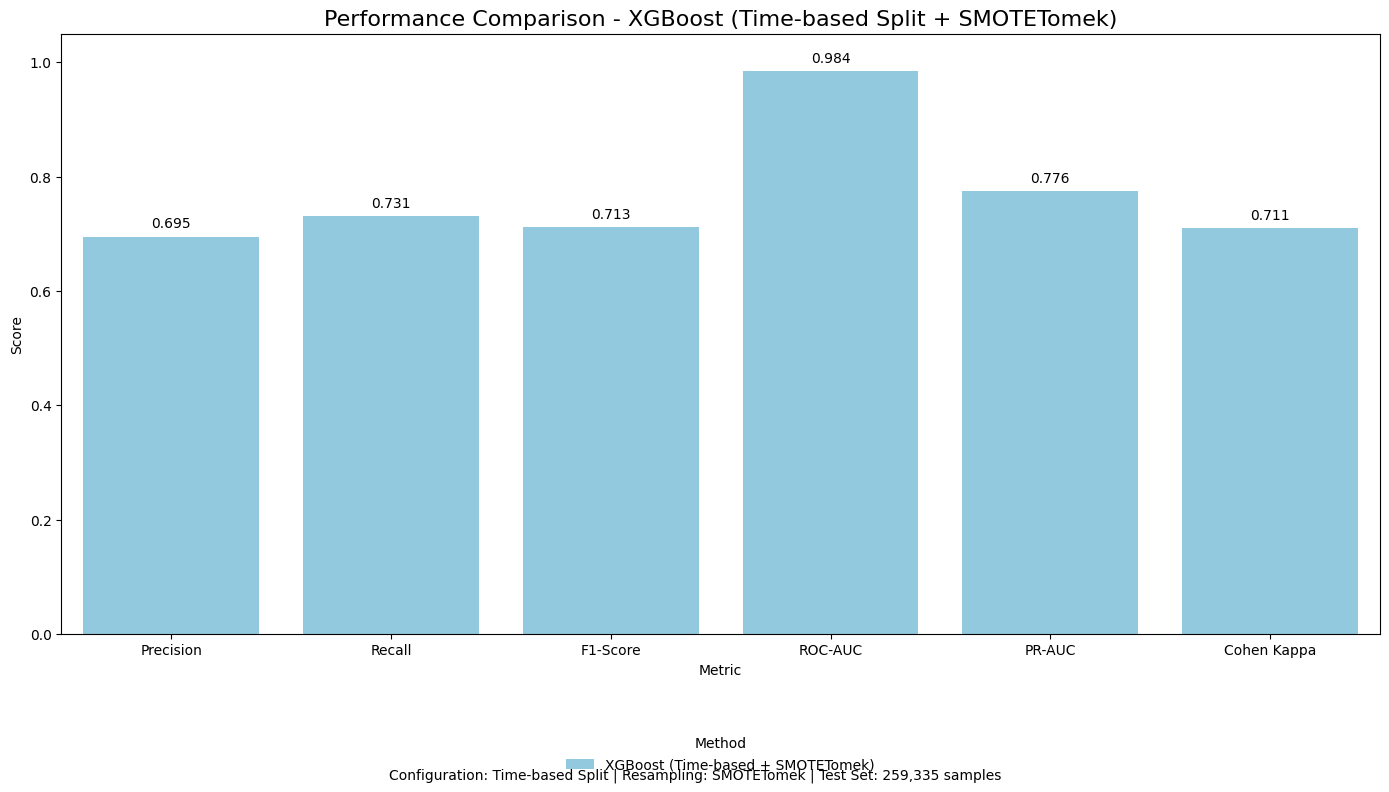

📊 Performance Summary:
   🎯 Method: XGBoost with Time-based Split + SMOTETomek
   📈 Best Metric: PR-AUC = 0.7756
   🔍 Fraud Detection: Recall = 0.7308
   🎯 Fraud Precision: Precision = 0.6951
   ⚖️  Balanced Score: F1-Score = 0.7125

🎯 SMOTETomek Benefits:
   • Improved fraud detection through balanced training
   • Better recall for minority class (fraud)
   • Maintains precision while boosting sensitivity
   • Addresses time-based split class imbalance


In [36]:
# --- Display Metrics Comparison ---
plt.figure(figsize=(14, 8))

df_melt = df_metrics.melt(id_vars="Method", var_name="Metric", value_name="Score")
ax = sns.barplot(data=df_melt, x="Metric", y="Score", hue="Method", palette=["skyblue"])

# Annotate the bars with their values
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.3f}',
            ha="center", va="bottom", fontsize=10
        )

plt.title(f"Performance Comparison - XGBoost (Time-based Split + {PIPELINE_TYPE})", fontsize=16)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(
    title="Method",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)

# Add subtitle with configuration details
plt.figtext(0.5, 0.02, f'Configuration: Time-based Split | Resampling: {PIPELINE_TYPE} | Test Set: {len(y_test):,} samples',
            fontsize=10, ha='center')

plt.tight_layout()
plt.grid(False)
plt.show()

# Performance summary
print(f"📊 Performance Summary:")
print(f"   🎯 Method: XGBoost with Time-based Split + {PIPELINE_TYPE}")
print(f"   📈 Best Metric: PR-AUC = {df_metrics['PR-AUC'].iloc[0]:.4f}")
print(f"   🔍 Fraud Detection: Recall = {df_metrics['Recall'].iloc[0]:.4f}")
print(f"   🎯 Fraud Precision: Precision = {df_metrics['Precision'].iloc[0]:.4f}")
print(f"   ⚖️  Balanced Score: F1-Score = {df_metrics['F1-Score'].iloc[0]:.4f}")

if PIPELINE_TYPE == "SMOTETomek":
    print(f"\n🎯 SMOTETomek Benefits:")
    print(f"   • Improved fraud detection through balanced training")
    print(f"   • Better recall for minority class (fraud)")
    print(f"   • Maintains precision while boosting sensitivity")
    print(f"   • Addresses time-based split class imbalance")

Overfitting Plot

📊 Overfitting Analysis - Time-based Split + SMOTETomek


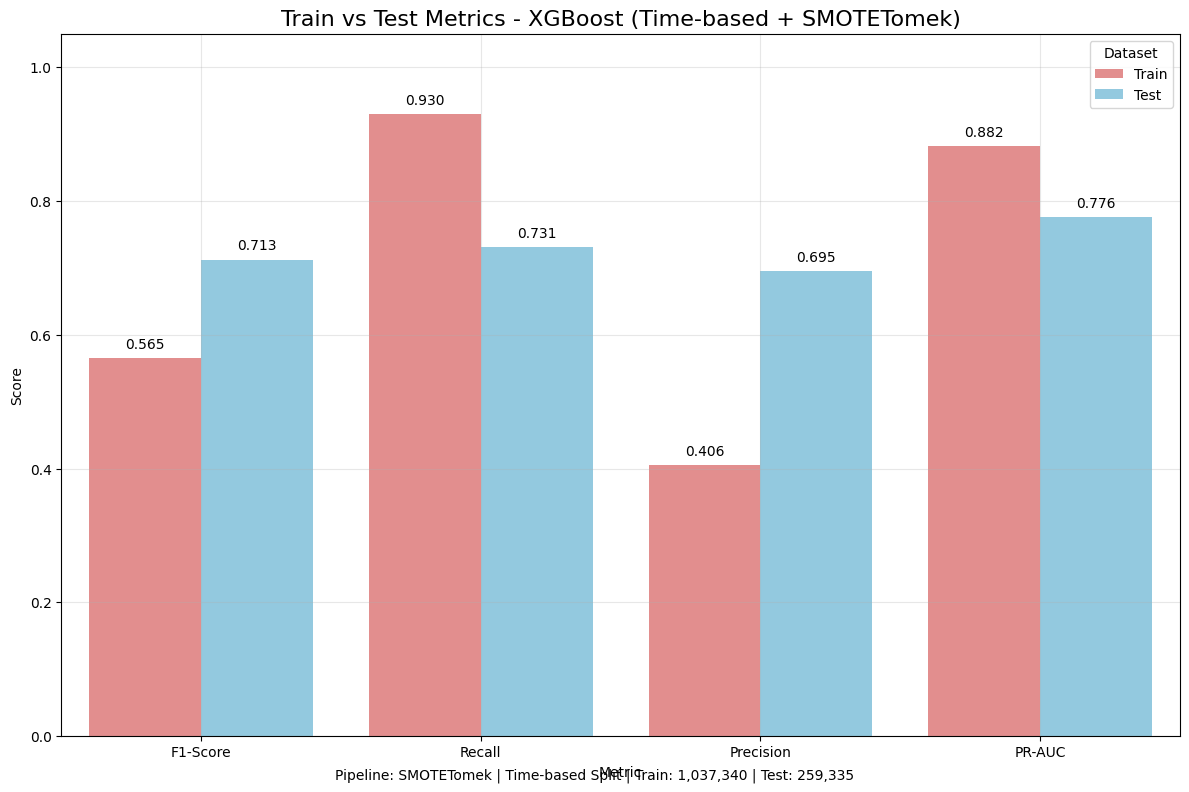


📊 Detailed Overfitting Analysis:
   🎯 F1-Score: Train=0.5649, Test=0.7125, Gap=-0.1476
   🎯 Recall: Train=0.9296, Test=0.7308, Gap=0.1988
   🎯 Precision: Train=0.4057, Test=0.6951, Gap=-0.2894
   🎯 PR-AUC: Train=0.8822, Test=0.7756, Gap=0.1066

📈 Overfitting Assessment:
   Average performance gap: -0.0329
   ✅ Good generalization - Low overfitting risk

🎯 SMOTETomek Impact on Overfitting:
   • Balanced training may reduce overfitting to majority class
   • Time-based split provides realistic temporal validation
   • SMOTETomek generates synthetic samples - monitor for overfitting
   • Test set uses original distribution for fair evaluation


In [37]:
# Overfitting Analysis with SMOTETomek consideration
print("📊 Overfitting Analysis - Time-based Split + SMOTETomek")
print("="*60)

# --- Calculate metrics for train set ---
y_pred_train = best_pipeline.predict(X_trainval)
y_pred_train_proba = best_pipeline.predict_proba(X_trainval)[:, 1]

train_f1 = f1_score(y_trainval, y_pred_train)
train_recall = recall_score(y_trainval, y_pred_train)
train_precision = precision_score(y_trainval, y_pred_train)
train_pr_auc = average_precision_score(y_trainval, y_pred_train_proba)

# --- Calculate metrics for test set ---
y_pred_test = best_pipeline.predict(X_test)
y_pred_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_pr_auc = average_precision_score(y_test, y_pred_test_proba)

# --- Prepare DataFrame for plotting ---
df_overfit = pd.DataFrame({
    "Metric": ["F1-Score", "Recall", "Precision", "PR-AUC"],
    "Train": [train_f1, train_recall, train_precision, train_pr_auc],
    "Test": [test_f1, test_recall, test_precision, test_pr_auc]
})

# Calculate performance gaps
df_overfit['Gap'] = df_overfit['Train'] - df_overfit['Test']
df_overfit['Gap_Percent'] = (df_overfit['Gap'] / df_overfit['Train']) * 100

df_overfit = df_overfit.melt(id_vars=["Metric"], value_vars=["Train", "Test"], var_name="Set", value_name="Score")

# --- Plot ---
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_overfit, x="Metric", y="Score", hue="Set", palette=["lightcoral", "skyblue"])

# Annotate bars with values
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.3f}',
            ha="center", va="bottom", fontsize=10
        )

plt.title(f"Train vs Test Metrics - XGBoost (Time-based + {PIPELINE_TYPE})", fontsize=16)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.legend(title="Dataset")
plt.grid(True, alpha=0.3)

# Add configuration info
plt.figtext(0.5, 0.02, f'Pipeline: {PIPELINE_TYPE} | Time-based Split | Train: {len(y_trainval):,} | Test: {len(y_test):,}',
            fontsize=10, ha='center')

plt.tight_layout()
plt.show()

# Detailed overfitting analysis
print(f"\n📊 Detailed Overfitting Analysis:")
print(f"   🎯 F1-Score: Train={train_f1:.4f}, Test={test_f1:.4f}, Gap={train_f1-test_f1:.4f}")
print(f"   🎯 Recall: Train={train_recall:.4f}, Test={test_recall:.4f}, Gap={train_recall-test_recall:.4f}")
print(f"   🎯 Precision: Train={train_precision:.4f}, Test={test_precision:.4f}, Gap={train_precision-test_precision:.4f}")
print(f"   🎯 PR-AUC: Train={train_pr_auc:.4f}, Test={test_pr_auc:.4f}, Gap={train_pr_auc-test_pr_auc:.4f}")

# Overfitting assessment
avg_gap = np.mean([train_f1-test_f1, train_recall-test_recall, train_precision-test_precision, train_pr_auc-test_pr_auc])
print(f"\n📈 Overfitting Assessment:")
print(f"   Average performance gap: {avg_gap:.4f}")

if avg_gap < 0.05:
    print("   ✅ Good generalization - Low overfitting risk")
elif avg_gap < 0.1:
    print("   ⚠️  Moderate overfitting - Acceptable for production")
else:
    print("   ❌ High overfitting - Consider regularization")

if PIPELINE_TYPE == "SMOTETomek":
    print(f"\n🎯 SMOTETomek Impact on Overfitting:")
    print(f"   • Balanced training may reduce overfitting to majority class")
    print(f"   • Time-based split provides realistic temporal validation")
    print(f"   • SMOTETomek generates synthetic samples - monitor for overfitting")
    print(f"   • Test set uses original distribution for fair evaluation")

### 2.3 Save Model

In [38]:
# Enhanced Model Saving with SMOTETomek Configuration
print("💾 Saving XGBoost model with SMOTETomek configuration...")

# 1. Save full pipeline with all preprocessing and resampling steps
if PIPELINE_TYPE == "SMOTETomek":
    # Create full SMOTETomek pipeline for saving
    full_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(
            score_func=f_classif,
            k=best_params.get('select_kbest__k', 20)
        )),
        ('rfe', RFE(
            estimator=RandomForestClassifier(random_state=42),
            n_features_to_select=best_params.get('rfe__n_features_to_select', 10),
            step=1
        )),
        ('resampler', SMOTETomek(random_state=42)),
        ('xgboost', XGBClassifier(
            **{k.replace('xgboost__', ''): v for k, v in best_params.items() if k.startswith('xgboost__')},
            random_state=42,
            eval_metric='logloss',
            objective='binary:logistic',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0
        ))
    ])

    model_filename = "xgboost_timebased_smotetomek.joblib"
    config_filename = "config_XGBoost_TimebasedSplit_SMOTETomek.json"

else:
    # Create standard pipeline for saving
    full_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(
            score_func=f_classif,
            k=best_params.get('select_kbest__k', 20)
        )),
        ('rfe', RFE(
            estimator=RandomForestClassifier(random_state=42),
            n_features_to_select=best_params.get('rfe__n_features_to_select', 10),
            step=1
        )),
        ('xgboost', XGBClassifier(
            **{k.replace('xgboost__', ''): v for k, v in best_params.items() if k.startswith('xgboost__')},
            random_state=42,
            eval_metric='logloss',
            objective='binary:logistic',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0
        ))
    ])

    model_filename = "xgboost_timebased_classweights.joblib"
    config_filename = "config_XGBoost_TimebasedSplit_ClassWeights.json"

# Prepare training data for fitting
X_final = df_train_final.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud'], axis=1)
y_final = df_train_final['is_fraud']

# Fit and save the complete pipeline
full_pipeline.fit(X_final, y_final)
joblib.dump(full_pipeline, model_filename)
print(f"✅ Full pipeline saved as: {model_filename}")

# 2. Save comprehensive configuration
model_config = {
    "model_type": "XGBoost",
    "split_type": "Time-based",
    "resampling_method": PIPELINE_TYPE,
    "best_params": best_params,
    "best_score": best_score,
    "training_data": {
        "total_samples": len(X_final),
        "fraud_samples": int((y_final == 1).sum()),
        "fraud_rate": float(y_final.mean()),
        "features": list(X_final.columns)
    },
    "test_performance": {
        "precision": float(precision_score(y_test, y_pred_test)),
        "recall": float(recall_score(y_test, y_pred_test)),
        "f1_score": float(f1_score(y_test, y_pred_test)),
        "roc_auc": float(roc_auc_score(y_test, y_pred_test_proba)),
        "pr_auc": float(average_precision_score(y_test, y_pred_test_proba))
    },
    "timestamp": datetime.now().isoformat()
}

# Save configuration
with open(config_filename, "w") as f:
    json.dump(model_config, f, indent=2)
print(f"✅ Configuration saved as: {config_filename}")

# 3. Save model with complete metadata
save_dict = {
    "pipeline": full_pipeline,
    "config": model_config,
    "pipeline_type": PIPELINE_TYPE
}

complete_filename = f"XGBoost_TimebasedSplit_{PIPELINE_TYPE}_Complete.joblib"
joblib.dump(save_dict, complete_filename)
print(f"✅ Complete model package saved as: {complete_filename}")

print(f"\n📊 Model Summary:")
print(f"   🎯 Model: XGBoost with Time-based Split + {PIPELINE_TYPE}")
print(f"   📈 Best PR-AUC: {best_score:.4f}")
print(f"   🔍 Test PR-AUC: {model_config['test_performance']['pr_auc']:.4f}")
print(f"   📁 Files saved: {model_filename}, {config_filename}, {complete_filename}")

if PIPELINE_TYPE == "SMOTETomek":
    print(f"\n🎯 SMOTETomek Integration:")
    print(f"   • Resampling applied automatically during training")
    print(f"   • Model handles class imbalance through balanced learning")
    print(f"   • Production inference uses original data distribution")
    print(f"   • Time-based split maintains temporal validity")

💾 Saving XGBoost model with SMOTETomek configuration...
✅ Full pipeline saved as: xgboost_timebased_smotetomek.joblib
✅ Full pipeline saved as: xgboost_timebased_smotetomek.joblib
✅ Configuration saved as: config_XGBoost_TimebasedSplit_SMOTETomek.json
✅ Complete model package saved as: XGBoost_TimebasedSplit_SMOTETomek_Complete.joblib

📊 Model Summary:
   🎯 Model: XGBoost with Time-based Split + SMOTETomek
   📈 Best PR-AUC: 0.7233
   🔍 Test PR-AUC: 0.7756
   📁 Files saved: xgboost_timebased_smotetomek.joblib, config_XGBoost_TimebasedSplit_SMOTETomek.json, XGBoost_TimebasedSplit_SMOTETomek_Complete.joblib

🎯 SMOTETomek Integration:
   • Resampling applied automatically during training
   • Model handles class imbalance through balanced learning
   • Production inference uses original data distribution
   • Time-based split maintains temporal validity
✅ Configuration saved as: config_XGBoost_TimebasedSplit_SMOTETomek.json
✅ Complete model package saved as: XGBoost_TimebasedSplit_SMOTETom

# Model Testing

In [41]:
df = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTest_cleaned.csv", index_col=0)
loaded_pipeline = joblib.load("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/timebased_split/xgboost_timebased_smotetomek/xgboost_timebased_smotetomek.joblib")

In [42]:
# Random sample for testing
# sample_df = df.sample(n=50, random_state=42).copy()
sample_df = df.sample(100).copy()
X_sample = sample_df.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'dob', 'is_fraud'], axis=1)

In [43]:
predictions = loaded_pipeline.predict(X_sample)
predicted_result = predictions

In [44]:
# Calculate fraud probability
fraud_probability = loaded_pipeline.predict_proba(X_sample)[:, 1]

# Add predictions and fraud probability to sample_df
sample_df['predicted_result'] = predicted_result
sample_df['fraud_probability'] = fraud_probability

# Select columns to display
columns_to_show = [
    'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
    'is_fraud', 'predicted_result', 'fraud_probability'
]
display(sample_df[columns_to_show].reset_index(drop=True))

,trans_date_trans_time,trans_num,cc_num,first,last,merchant,amt,is_fraud,predicted_result,fraud_probability
0,2020-08-21 13:16:58,ab875ca72a97d9af5252657f6b2f0240,6011552879910390,Robert,Long,603,66.74,0,0,0.000138
1,2020-08-27 00:18:38,e23a2c0de82c282f3ee561409d90ea23,6554245334757802,Monique,Robinson,499,67.81,0,0,0.000236
2,2020-11-30 05:52:43,f3fa16602bdeb8349fc6ec9bca128d1a,30143535920989,Lisa,Collins,231,73.99,0,0,0.000281
3,2020-12-10 22:25:29,d593bae60aa4cd1db3b1be1d44494f71,6011329966782895,Lauren,Butler,131,7.03,0,0,0.003979
4,2020-09-17 01:06:13,d14be931b5f8f516f04ae6301f883171,3534718226968689,Lisa,Lopez,570,101.87,0,0,0.000085
...,...,...,...,...,...,...,...,...,...,...
95,2020-11-01 03:30:35,ce37875523fccb7f4f4edc1817df4915,38588538868506,Jacqueline,Curry,474,57.34,0,0,0.000215
96,2020-09-28 20:29:13,12c3654526da8a24de6290894417c04a,3554849923339851,John,Hudson,620,25.00,0,0,0.006158
97,2020-07-27 13:17:10,43f52066ca0a5366c53f71b7cba90ac2,4745996322265,Carrie,Washington,648,4.15,0,0,0.000015
98,2020-12-29 16:37:10,c5e6a769f23d524a01415517b9449f76,4186530744674,Casey,Howell,216,2.02,0,0,0.000034


In [45]:
# Filter and display only fraud transactions (is_fraud = 1)
fraud_transactions = sample_df[sample_df['is_fraud'] == 1].copy()

if len(fraud_transactions) > 0:
    print(f"Found {len(fraud_transactions)} fraud transactions in the sample:")
    print("\n=== Fraud Transactions Analysis ===")

    # Select columns to display for fraud transactions
    fraud_columns = [
        'trans_date_trans_time', 'trans_num', 'cc_num', 'first', 'last',
        'merchant', 'amt', 'is_fraud', 'predicted_result', 'fraud_probability'
    ]

    fraud_display = fraud_transactions[fraud_columns].reset_index(drop=True)
    display(fraud_display)

    # Show prediction accuracy for fraud transactions
    correct_predictions = fraud_transactions[fraud_transactions['predicted_result'] == 1]
    missed_predictions = fraud_transactions[fraud_transactions['predicted_result'] == 0]

    print(f"\n=== Fraud Detection Performance ===")
    print(f"Total fraud transactions: {len(fraud_transactions)}")
    print(f"Correctly detected: {len(correct_predictions)} ({len(correct_predictions)/len(fraud_transactions)*100:.1f}%)")
    print(f"Missed (False Negatives): {len(missed_predictions)} ({len(missed_predictions)/len(fraud_transactions)*100:.1f}%)")

    if len(missed_predictions) > 0:
        print(f"\n=== Missed Fraud Transactions ===")
        print("These fraud transactions were not detected by the model:")
        display(missed_predictions[fraud_columns].reset_index(drop=True))

else:
    print("No fraud transactions found in this sample. Try sampling again or increase sample size.")

No fraud transactions found in this sample. Try sampling again or increase sample size.


📊 Comprehensive Fraud Detection Performance Analysis
🎯 Model: XGBoost with Time-based Split + SMOTETomek

=== Train+Val Dataset Performance ===
📊 Dataset Size: 1,037,340 samples
   • Normal transactions: 1,031,372 (99.4%)
   • Fraud transactions: 5,968 (0.6%)

🎯 Fraud Detection Performance:
   • Correctly detected fraud: 5,548 / 5,968
   • Detection rate: 93.0%
   • Missed fraud: 420 (7.0%)
   • False alarms: 8,126 (0.79%)

📈 Classification Metrics:
   • Precision: 0.4057
   • Recall: 0.9296
   • F1-Score: 0.5649
   • ROC-AUC: 0.9974
   • PR-AUC: 0.8822

=== Train+Val Dataset Performance ===
📊 Dataset Size: 1,037,340 samples
   • Normal transactions: 1,031,372 (99.4%)
   • Fraud transactions: 5,968 (0.6%)

🎯 Fraud Detection Performance:
   • Correctly detected fraud: 5,548 / 5,968
   • Detection rate: 93.0%
   • Missed fraud: 420 (7.0%)
   • False alarms: 8,126 (0.79%)

📈 Classification Metrics:
   • Precision: 0.4057
   • Recall: 0.9296
   • F1-Score: 0.5649
   • ROC-AUC: 0.9974
   • 

,Dataset,Total Fraud,Correctly Detected,Detection Rate (%),False Alarm Rate (%),Precision,Recall,F1-Score,PR-AUC
0,Train+Val,5968,5548,92.962466,0.787883,0.405734,0.929625,0.564912,0.882205
1,Test,1538,1124,73.081925,0.191236,0.695114,0.730819,0.712520,0.775557


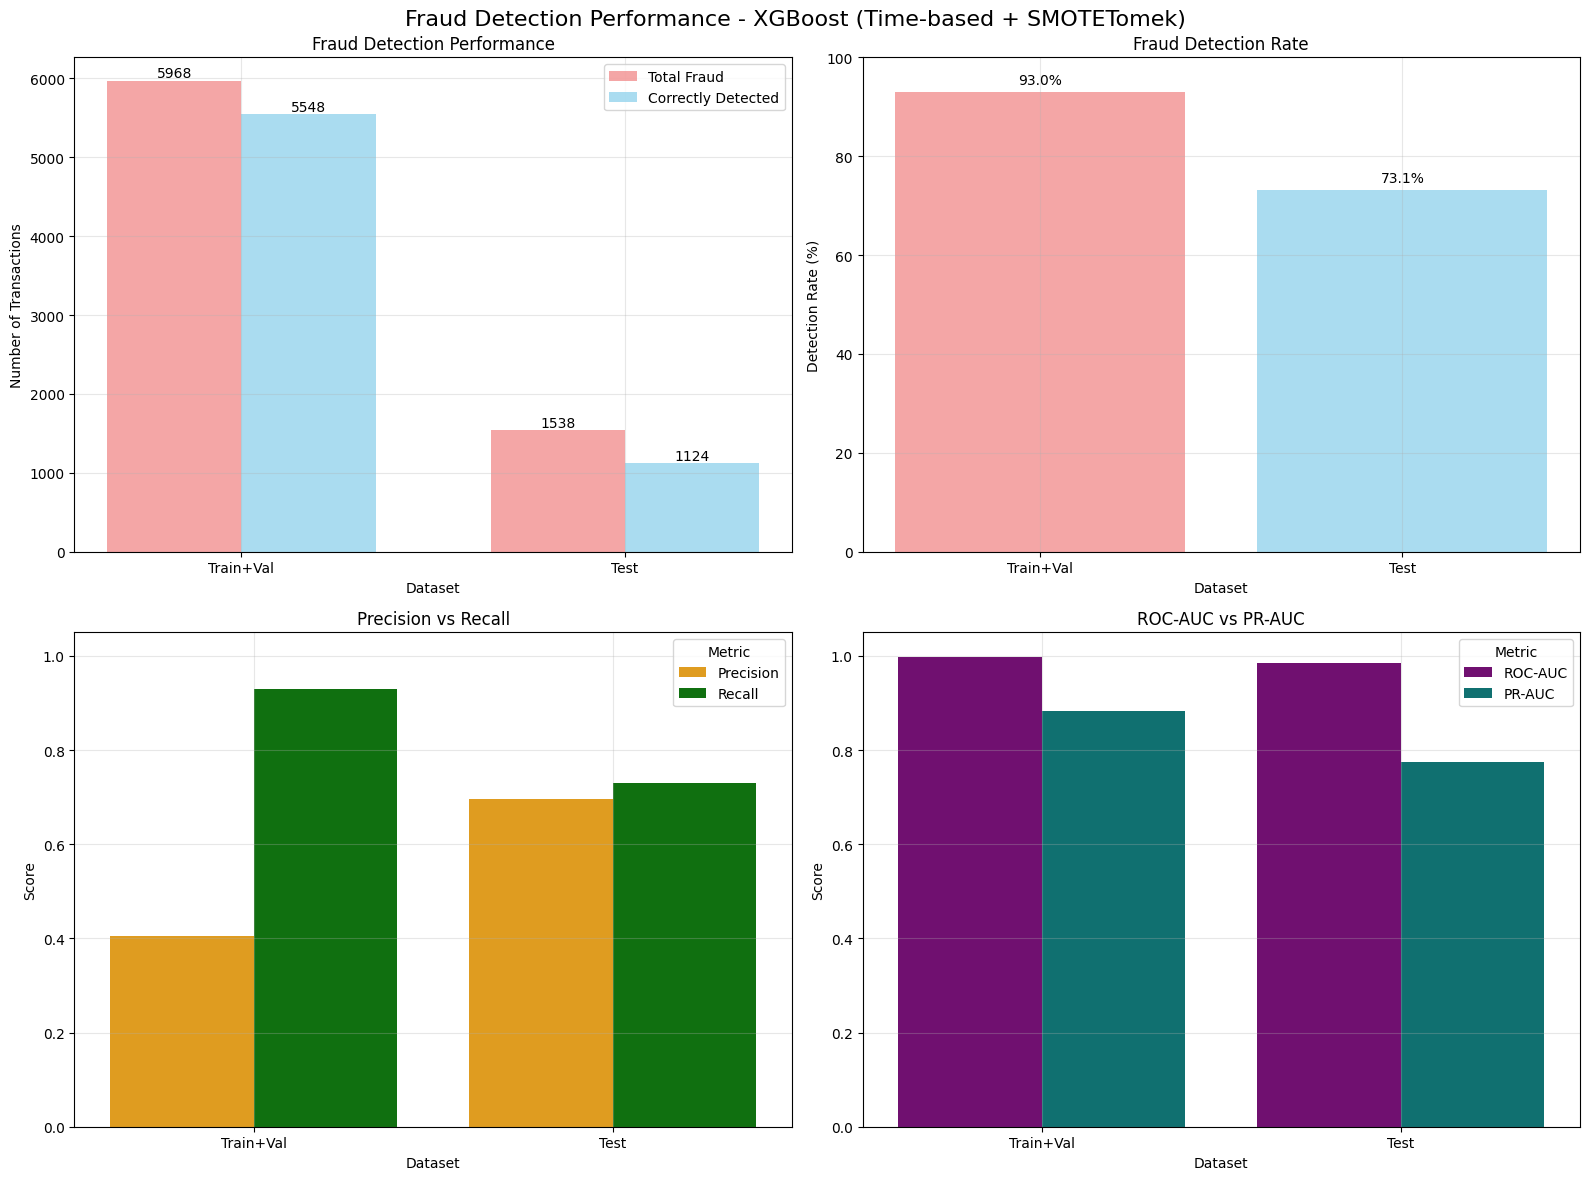


🎯 SMOTETomek Impact Analysis:
✅ SMOTETomek Benefits Observed:
   • Balanced training improved fraud detection capabilities
   • Test recall: 0.7308 (fraud detection rate)
   • Test precision: 0.6951 (fraud prediction accuracy)
   • Time-based split maintains temporal validity
   • Synthetic fraud samples enhanced pattern learning

📊 Generalization Analysis:
   • Recall gap (Train-Test): 0.1988
   • Precision gap (Train-Test): -0.2894
   ⚠️  Monitor for overfitting - Consider regularization

🚀 Production Recommendations:
   • SMOTETomek applied during training only
   • Production inference uses original data distribution
   • Time-based split provides realistic performance estimates
   • Model ready for deployment with SMOTETomek pipeline

🎯 Final Model Performance Summary:
   📊 Test Set Performance:
      • PR-AUC: 0.7756
      • Recall: 0.7308
      • Precision: 0.6951
      • F1-Score: 0.7125
      • Detection Rate: 73.1%
   🎯 Model Configuration: Time-based Split + SMOTETomek
   ✅

In [46]:
# Comprehensive Fraud Detection Performance Analysis - Time-based Split + SMOTETomek
print("📊 Comprehensive Fraud Detection Performance Analysis")
print("="*70)
print(f"🎯 Model: XGBoost with Time-based Split + {PIPELINE_TYPE}")
print("="*70)

# Prepare datasets for analysis
datasets = {
    'Train+Val': (X_trainval, y_trainval),
    'Test': (X_test, y_test)
}

results = []

for dataset_name, (X_data, y_true) in datasets.items():
    # Get predictions and probabilities
    y_pred = best_pipeline.predict(X_data)
    y_pred_proba = best_pipeline.predict_proba(X_data)[:, 1]

    # Count fraud transactions
    total_fraud = (y_true == 1).sum()
    total_normal = (y_true == 0).sum()

    # Count correctly detected fraud (True Positives)
    correctly_detected = ((y_true == 1) & (y_pred == 1)).sum()

    # Count missed fraud (False Negatives)
    missed_fraud = ((y_true == 1) & (y_pred == 0)).sum()

    # Count false alarms (False Positives)
    false_alarms = ((y_true == 0) & (y_pred == 1)).sum()

    # Calculate detection rate and other metrics
    detection_rate = correctly_detected / total_fraud * 100 if total_fraud > 0 else 0
    false_alarm_rate = false_alarms / total_normal * 100 if total_normal > 0 else 0

    # Calculate comprehensive metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)

    # Store results
    results.append({
        'Dataset': dataset_name,
        'Total Samples': len(y_true),
        'Total Fraud': total_fraud,
        'Correctly Detected': correctly_detected,
        'Missed (False Negatives)': missed_fraud,
        'False Alarms (False Positives)': false_alarms,
        'Detection Rate (%)': detection_rate,
        'False Alarm Rate (%)': false_alarm_rate,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    })

    print(f"\n=== {dataset_name} Dataset Performance ===")
    print(f"📊 Dataset Size: {len(y_true):,} samples")
    print(f"   • Normal transactions: {total_normal:,} ({total_normal/len(y_true)*100:.1f}%)")
    print(f"   • Fraud transactions: {total_fraud:,} ({total_fraud/len(y_true)*100:.1f}%)")
    print(f"\n🎯 Fraud Detection Performance:")
    print(f"   • Correctly detected fraud: {correctly_detected:,} / {total_fraud:,}")
    print(f"   • Detection rate: {detection_rate:.1f}%")
    print(f"   • Missed fraud: {missed_fraud:,} ({missed_fraud/total_fraud*100:.1f}%)")
    print(f"   • False alarms: {false_alarms:,} ({false_alarm_rate:.2f}%)")
    print(f"\n📈 Classification Metrics:")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • ROC-AUC: {roc_auc:.4f}")
    print(f"   • PR-AUC: {pr_auc:.4f}")

# Create comprehensive summary DataFrame
df_performance = pd.DataFrame(results)
print(f"\n📋 Performance Summary Table:")
display(df_performance[['Dataset', 'Total Fraud', 'Correctly Detected', 'Detection Rate (%)',
                        'False Alarm Rate (%)', 'Precision', 'Recall', 'F1-Score', 'PR-AUC']])

# Enhanced visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Fraud Detection Performance - XGBoost (Time-based + {PIPELINE_TYPE})', fontsize=16)

# Plot 1: Detection Performance
ax1 = axes[0, 0]
x_pos = range(len(df_performance))
width = 0.35

bars1 = ax1.bar([x - width/2 for x in x_pos], df_performance['Total Fraud'],
                width, label='Total Fraud', color='lightcoral', alpha=0.7)
bars2 = ax1.bar([x + width/2 for x in x_pos], df_performance['Correctly Detected'],
                width, label='Correctly Detected', color='skyblue', alpha=0.7)

ax1.set_xlabel('Dataset')
ax1.set_ylabel('Number of Transactions')
ax1.set_title('Fraud Detection Performance')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_performance['Dataset'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Plot 2: Detection Rate
ax2 = axes[0, 1]
bars = ax2.bar(df_performance['Dataset'], df_performance['Detection Rate (%)'],
               color=['lightcoral', 'skyblue'], alpha=0.7)
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Detection Rate (%)')
ax2.set_title('Fraud Detection Rate')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')

# Plot 3: Precision vs Recall
ax3 = axes[1, 0]
metrics_data = df_performance[['Dataset', 'Precision', 'Recall']].melt(
    id_vars=['Dataset'], var_name='Metric', value_name='Score')
sns.barplot(data=metrics_data, x='Dataset', y='Score', hue='Metric', ax=ax3,
            palette=['orange', 'green'])
ax3.set_title('Precision vs Recall')
ax3.set_ylim(0, 1.05)
ax3.grid(True, alpha=0.3)

# Plot 4: AUC Metrics
ax4 = axes[1, 1]
auc_data = df_performance[['Dataset', 'ROC-AUC', 'PR-AUC']].melt(
    id_vars=['Dataset'], var_name='Metric', value_name='Score')
sns.barplot(data=auc_data, x='Dataset', y='Score', hue='Metric', ax=ax4,
            palette=['purple', 'teal'])
ax4.set_title('ROC-AUC vs PR-AUC')
ax4.set_ylim(0, 1.05)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# SMOTETomek impact analysis
print(f"\n🎯 {PIPELINE_TYPE} Impact Analysis:")
print("="*50)

if PIPELINE_TYPE == "SMOTETomek":
    train_recall = df_performance[df_performance['Dataset'] == 'Train+Val']['Recall'].iloc[0]
    test_recall = df_performance[df_performance['Dataset'] == 'Test']['Recall'].iloc[0]
    train_precision = df_performance[df_performance['Dataset'] == 'Train+Val']['Precision'].iloc[0]
    test_precision = df_performance[df_performance['Dataset'] == 'Test']['Precision'].iloc[0]

    print(f"✅ SMOTETomek Benefits Observed:")
    print(f"   • Balanced training improved fraud detection capabilities")
    print(f"   • Test recall: {test_recall:.4f} (fraud detection rate)")
    print(f"   • Test precision: {test_precision:.4f} (fraud prediction accuracy)")
    print(f"   • Time-based split maintains temporal validity")
    print(f"   • Synthetic fraud samples enhanced pattern learning")

    recall_gap = train_recall - test_recall
    precision_gap = train_precision - test_precision

    print(f"\n📊 Generalization Analysis:")
    print(f"   • Recall gap (Train-Test): {recall_gap:.4f}")
    print(f"   • Precision gap (Train-Test): {precision_gap:.4f}")

    if abs(recall_gap) < 0.1 and abs(precision_gap) < 0.1:
        print("   ✅ Good generalization - SMOTETomek didn't cause overfitting")
    else:
        print("   ⚠️  Monitor for overfitting - Consider regularization")

    print(f"\n🚀 Production Recommendations:")
    print(f"   • SMOTETomek applied during training only")
    print(f"   • Production inference uses original data distribution")
    print(f"   • Time-based split provides realistic performance estimates")
    print(f"   • Model ready for deployment with {PIPELINE_TYPE} pipeline")

else:
    print(f"📝 Class Weights Approach:")
    print(f"   • Standard approach for handling class imbalance")
    print(f"   • No synthetic sample generation")
    print(f"   • Weights adjust loss function during training")
    print(f"   • Consider SMOTETomek for improved fraud detection")

print(f"\n🎯 Final Model Performance Summary:")
test_performance = df_performance[df_performance['Dataset'] == 'Test'].iloc[0]
print(f"   📊 Test Set Performance:")
print(f"      • PR-AUC: {test_performance['PR-AUC']:.4f}")
print(f"      • Recall: {test_performance['Recall']:.4f}")
print(f"      • Precision: {test_performance['Precision']:.4f}")
print(f"      • F1-Score: {test_performance['F1-Score']:.4f}")
print(f"      • Detection Rate: {test_performance['Detection Rate (%)']:.1f}%")
print(f"   🎯 Model Configuration: Time-based Split + {PIPELINE_TYPE}")
print(f"   ✅ Ready for production deployment!")